# Data Assignment 1 - `t54zheng` (20939203)

## Task 3 - Indexing

In [1]:
# imports

import pandas as pd
import scipy.stats as stats
from math import sqrt
import warnings
import matplotlib.pyplot as plt
from datetime import timedelta
import numpy as np
from scipy.optimize import minimize

warnings.filterwarnings('ignore')

In [2]:
# Import raw data
data_file = "djreturns.xlsx"

dj27 = pd.read_excel(data_file, sheet_name="dj27")
individual_dj27_returns = pd.read_excel(data_file, sheet_name="returns")
sp500_returns = pd.read_excel(data_file, sheet_name="sp500")

In [3]:
# Also we carry forward the returns df from Task 2

returns_dict = {} # permno -> dataframe(permno_returns)
permnos = dj27["PERMNO"]
for permno in permnos:
    returns_df = individual_dj27_returns[individual_dj27_returns["PERMNO"] == permno]
    returns_dict[permno] = returns_df

***

## Task 3 - Equal-weighted Portfolio

In [4]:
individual_dj27_returns

,PERMNO,DATE,COMNAM,TICKER,PRC,RET,SHROUT
0,10107,2000-01-31,MICROSOFT CORP,MSFT,97.875000,-0.161670,5160025
1,10107,2000-02-29,MICROSOFT CORP,MSFT,89.375000,-0.086845,5160025
2,10107,2000-03-31,MICROSOFT CORP,MSFT,106.250000,0.188811,5242000
3,10107,2000-04-28,MICROSOFT CORP,MSFT,69.750000,-0.343529,5262405
4,10107,2000-05-31,MICROSOFT CORP,MSFT,62.562500,-0.103047,5262405
...,...,...,...,...,...,...,...
7123,92655,2021-08-31,UNITEDHEALTH GROUP INC,UNH,416.269989,0.009825,942917
7124,92655,2021-09-30,UNITEDHEALTH GROUP INC,UNH,390.739990,-0.057847,942917
7125,92655,2021-10-29,UNITEDHEALTH GROUP INC,UNH,460.470001,0.178456,942917
7126,92655,2021-11-30,UNITEDHEALTH GROUP INC,UNH,444.220001,-0.035290,941851


To make our equally-weighted index we will allocate each ticker an equal weight of $\dfrac{1}{n}$, and since we have 27 stocks, we allocate each stock a weight of $\dfrac{1}{27}$.

In [5]:
# We only need to use monthly returns (already calculated) to calculate the index. So let's align the data.
# This df will hold our (unindexed [to 1000]) portfolio

# We'll just pull the dates from the sp500 returns since that, and the dj data all have aligned dates
portfolio_df = pd.DataFrame(sp500_returns["DATE"])

for permno, df in returns_dict.items():
    portfolio_df.loc[:, permno] = list(df["RET"])

# Just to validate, none of our cells are null so we can safely continue 
portfolio_df.isnull().sum().sum() # returns number of null cells

0

* Note that the reason why we can just multiply all of the returns by $\dfrac{1}{27}$ is because we are creating an equally weighted portfolio. Therefore we are not concerned with lookahead bias since the weights at all times are the same for each stock.

In [6]:
num_stocks = 27
weight = 1 / num_stocks
starting_level = 1000

portfolio_df.iloc[:, 1:] *= weight # Weighted average of portfolio returns
portfolio_df.loc[:, "Weighted Return"] = portfolio_df.iloc[:, 1:].sum(axis=1)
portfolio_df

,DATE,10107,10145,11308,12490,14008,14541,14593,18163,18542,...,57665,59176,59328,59459,65875,66181,76076,86868,92655,Weighted Return
0,2000-01-31,-0.005988,-0.006220,-0.000517,0.001502,0.002235,-0.001283,0.000338,-0.002765,-0.003384,...,-0.003036,-0.000284,0.007481,-0.003848,0.000457,-0.006532,0.000821,-0.000960,-0.000087,-0.018881
1,2000-02-29,-0.003216,0.000241,-0.005683,-0.003095,0.002617,-0.003670,0.003882,-0.004833,-0.006436,...,-0.013889,-0.006871,0.005275,-0.009585,-0.007774,0.000777,0.007674,0.000354,-0.001310,-0.083481
2,2000-03-31,0.006993,0.003511,-0.001156,0.005497,-0.003700,0.008802,0.006846,-0.013224,0.004621,...,0.014727,0.004071,0.006207,0.019897,0.009224,0.004310,0.006287,0.005105,0.006179,0.119399
3,2000-04-28,-0.012723,0.002329,0.000247,-0.002040,-0.003244,-0.002930,-0.003204,0.002340,0.000305,...,0.003564,0.000200,-0.001439,0.001628,-0.000903,-0.004594,-0.003825,-0.004181,0.004387,-0.013185
4,2000-05-31,-0.003817,-0.000744,0.004801,-0.001327,0.005043,0.003464,-0.011960,0.004184,-0.001115,...,-0.000480,0.003097,-0.000612,0.001949,-0.003985,-0.005039,-0.006619,-0.007819,0.004374,-0.010932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,2021-08-31,0.002279,-0.000150,-0.000468,0.000268,-0.002185,-0.001346,0.001572,0.000042,0.000738,...,-0.000552,-0.000993,0.000474,0.002684,-0.000518,-0.000227,0.002441,0.004014,0.000364,0.014411
260,2021-09-30,-0.002449,-0.003135,-0.002249,-0.000372,-0.002115,0.001791,-0.002520,-0.000674,-0.003320,...,-0.004386,0.000350,-0.000534,-0.001582,-0.000667,0.000424,-0.002880,-0.003178,-0.002142,-0.041907
261,2021-10-29,0.006529,0.001106,0.002753,-0.003687,-0.000989,0.004761,0.002172,0.001076,0.002537,...,0.005626,0.001477,-0.002975,0.002161,-0.000261,0.004906,0.001300,0.003460,0.006609,0.048706
262,2021-11-30,-0.000046,-0.002609,-0.002300,-0.000348,-0.001133,-0.000091,0.003887,0.000412,-0.001935,...,0.000432,-0.004578,0.000414,-0.003207,-0.001901,0.002876,-0.000748,-0.002900,-0.001307,-0.036266


To avoid look-ahead bias, we calculate the index level $L_t$ as $L_{t-1} \times r_{p,t}$

In [7]:
# Now we'll use this data to populate our index_df 
index_returns_df = portfolio_df[["DATE", "Weighted Return"]]

index_df = pd.DataFrame(columns = ["Date", "Index Level"])
index_df.loc[0] = ["1999-12-31", 1000.00]

for index, row in index_returns_df.iterrows():
    index_df.loc[index + 1, "Date"] = str(index_returns_df.loc[index, "DATE"])
    index_df.loc[index + 1, "Index Level"] = (1+ index_returns_df.loc[index, "Weighted Return"]) * index_df.loc[index, "Index Level"]
index_df["Date"] = pd.to_datetime(index_df["Date"], format='mixed') # Fix datetime

index_df["Index Level"] = index_df["Index Level"].round(2)
index_df

,Date,Index Level
0,1999-12-31,1000.00
1,2000-01-31,981.12
2,2000-02-29,899.21
3,2000-03-31,1006.58
4,2000-04-28,993.31
...,...,...
260,2021-08-31,11319.80
261,2021-09-30,10845.42
262,2021-10-29,11373.66
263,2021-11-30,10961.18


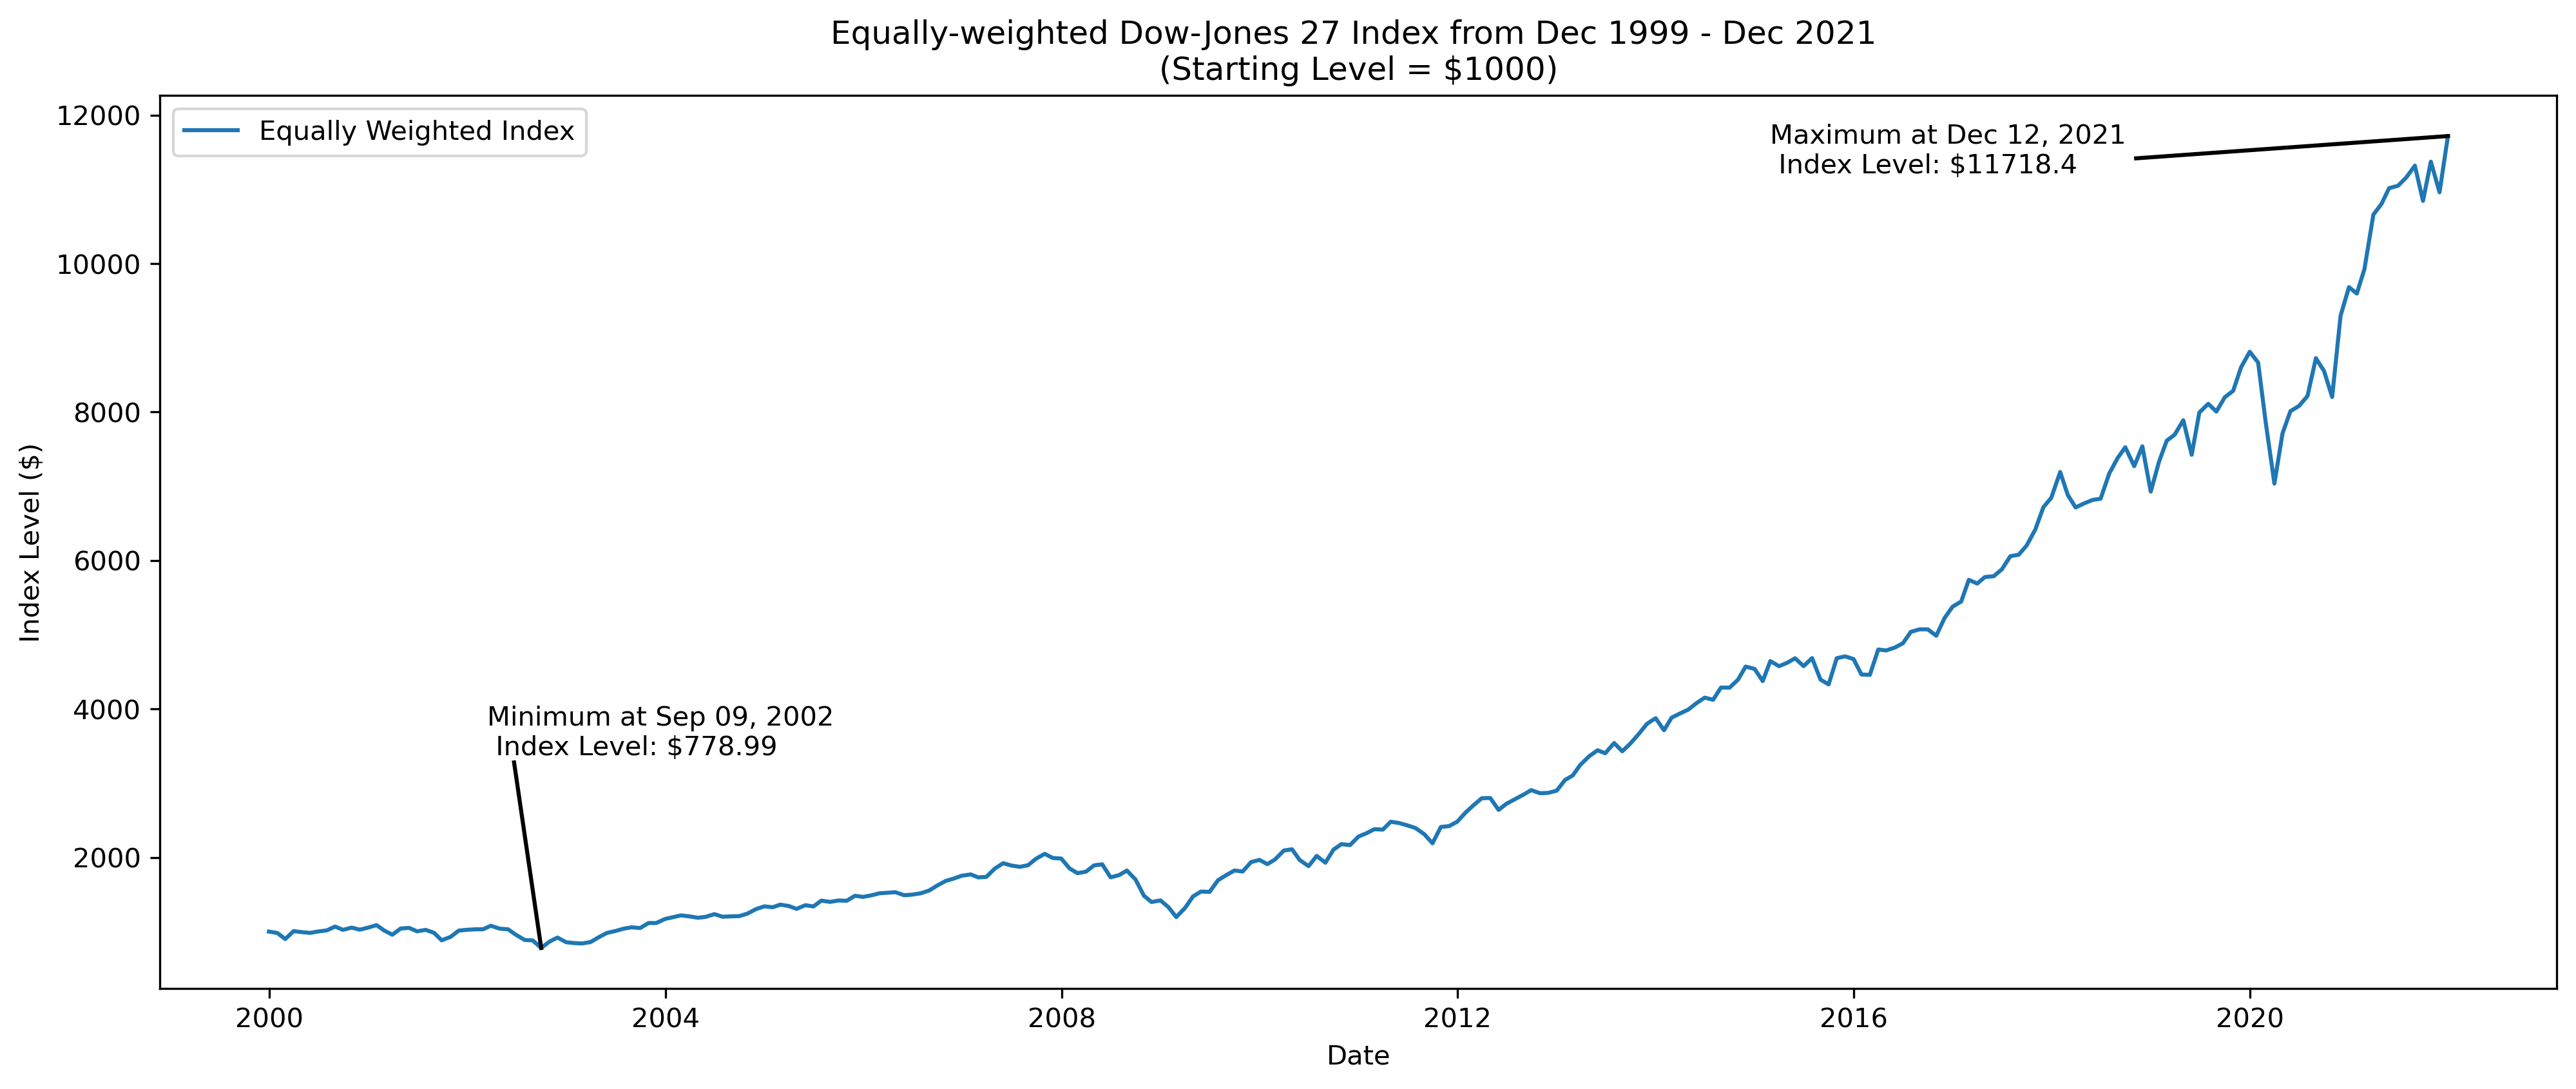

In [12]:
index_df.set_index(["Date"])

plt.figure(figsize=(16, 6), dpi=300)

plt.plot(index_df["Date"], index_df["Index Level"], label="Equally Weighted Index")

# We need to find (and annotate the min and max)

# Min
min_y = min(index_df["Index Level"])
min_x = index_df[index_df["Index Level"] == min_y]["Date"].iloc[0]

# Plot minimum
plt.plot([min_x, min_x - timedelta(100)], [min_y, min_y + 2500], linestyle="-", color="black")
plt.text(min_x - timedelta(200), min_y + 2600, f"Minimum at {min_x.strftime('%b %m, %Y')}\n Index Level: ${min_y}")

# Max
max_y = max(index_df["Index Level"])
max_x = index_df[index_df["Index Level"] == max_y]["Date"].iloc[0]

# Plot maximum
plt.plot([max_x, max_x - timedelta(1150)], [max_y, max_y - 300], linestyle="-", color="black")
plt.text(max_x - timedelta(2500), max_y - 500, f"Maximum at {max_x.strftime('%b %m, %Y')}\n Index Level: ${max_y}")
plt.legend()

plt.title("Equally-weighted Dow-Jones 27 Index from Dec 1999 - Dec 2021 \n" +
          "(Starting Level = $1000)")
plt.ylabel("Index Level ($)")
plt.xlabel("Date")
plt.show()